In [2]:
import pandas as pd
import numpy as np

import re

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer

from collections import Counter, defaultdict
from functools import lru_cache, reduce
from itertools import chain, combinations

import tqdm

In [3]:
pd.options.display.max_colwidth = 100
pd.options.display.max_columns = 300

init_notebook_mode(connected=True)

## здесь термины -  ЯП с вики 

https://en.wikipedia.org/wiki/List_of_programming_languages

In [4]:
languages = open('data/programming_languages.txt').read().split('\n')

In [5]:
fin_df = pd.read_csv('./data/df_hni_2018_05.csv', low_memory=False)

# read lists from csv
for list_col in \
    ['text_sentences', 'text_words', 'title_words', 'lengths_of_text_words', 'lengths_of_title_words']:
    fin_df[list_col] = fin_df[list_col].apply(eval)

In [6]:
def which_tech(words, techs):
    return set(words) & techs

In [10]:
fin_df['all_words'] = fin_df['text_words']  + fin_df['title_words']
fin_df['languages'] = fin_df['all_words'].apply(lambda x: which_tech(x, set(languages)))


### ЯП для 90% записей не сматчились (не обнаружены)

In [8]:
(fin_df['languages'] == set()).mean()

0.9089780598032368

In [9]:
langs_pop = Counter(fin_df['languages'].apply(lambda x: list(x)).sum())

In [10]:
langs_pop.most_common(10)

[('C', 3514),
 ('Python', 2051),
 ('Java', 1372),
 ('Go', 1354),
 ('S', 1329),
 ('JavaScript', 1048),
 ('D', 954),
 ('Rust', 909),
 ('B', 865),
 ('E', 732)]

In [11]:
fin_df.loc[498:498]['text'].values

array(["Who's supplying the gigabit fiber connectivity, out there?<p>P.S.  Answered my own question.  Information may be out of date, but quite limited coverage residential plans from a couple of companies, and somewhat more but still limited coverage from a few companies business class offers.<p>Wish I had that many choices.  ATT finally dropped a fiber line into our neighborhood, but it's not hooked up yet.  Given what Comcast is doing to its cable Internet pricing, here, I'm a bit afraid to see the pricing ATT will offer us.  By contrast, pricing out there looks significantly better.<p>Prior to this, our local copper trunk has been so old/deteriorated that DSL was marginal at best (they wouldn't sell it) and Uverse was a non-starter.<p>I might not want to be in Manhattan, KS, but I can think of some other towns -- maybe I need to look again."],
      dtype=object)

In [ ]:
fin_df[fin_df['languages'].apply(lambda x: x & {'S', 'D', 'E'} != set())][['languages', 'all_words']].head(4)

### Самые очевидные ошибки, если матчить по словам через nltk

* P.S. как ЯП
* R&D как ЯП
* теги < p >
* C# -> C

In [11]:
def text2tokens(text):
    
    # delete html tags & "'s " example: "Python's "
    text = re.sub(r'<\w+>', ' ', text)
    text = re.sub(r'\'s\s', ' ', text)
    
    # to sentences
    snts = re.split(r'[;\.\!\?]', text)
    # sentences to words
    snts = list(map(lambda x: x.split(), snts))
    # filter small sentences
    snts = list(filter(lambda x: len(x) > 1, snts))
    
    # sentences to tokens
    tokens = list(chain(*snts))
    
    # delete some punctuation on both sides of the words 
    safe_punctuation = re.escape('!"\'(),.:;?[\\]`{|}')
    
    tokens = list(map(lambda x: 
                  re.sub('(^[{p}]*|[{p}]*$)'.format(p=safe_punctuation), '', x), tokens))
    return tokens

In [13]:
fin_df['all_text'] = fin_df['text'].fillna('') + fin_df['title'].fillna('') 
fin_df['all_tokens'] = fin_df['all_text'].apply(text2tokens)

fin_df['languages_2'] = fin_df['all_tokens'].apply(lambda x: which_tech(x, set(languages)))

In [14]:
fin_df[fin_df['languages_2']!=set()].head(3)

,by,dead,deleted,descendants,id,kids,parent,parts,poll,retrieved_on,score,text,time,title,type,url,text_sentences,text_words,title_words,text_words_count,title_words_count,text_sentences_count,lengths_of_text_words,lengths_of_title_words,netloc,techs,day,all_words,languages,all_text,all_tokens,languages_2
7,yodon,NaN,NaN,NaN,16963608,[16966314],16962948.0,NaN,NaN,1528401049,NaN,(Retyped is part of the Bridge.NET C# -> JS/TypeScript converter)<p>It’s super exciting too see ...,1525132905,NaN,comment,NaN,[(Retyped is part of the Bridge.NET C# -> JS/TypeScript converter)<p>It’s super exciting too see...,"[Retyped, is, part, of, the, Bridge, NET, C, JS, TypeScript, converter, p, It, s, super, excitin...",[],96,0,1,"[7, 2, 4, 2, 3, 6, 3, 1, 2, 10, 9, 1, 2, 1, 5, 8, 3, 3, 6, 11, 3, 5, 2, 1, 5, 4, 8, 4, 1, 6, 3, ...",[],NaN,{'TypeScript'},2018-05-01,"[Retyped, is, part, of, the, Bridge, NET, C, JS, TypeScript, converter, p, It, s, super, excitin...","{TypeScript, C}",(Retyped is part of the Bridge.NET C# -> JS/TypeScript converter)<p>It’s super exciting too see ...,"[Retyped, is, part, of, the, Bridge, NET, C#, ->, JS/TypeScript, converter, It’s, super, excitin...","{TypeScript, C#}"
18,dfox,NaN,NaN,NaN,16963619,NaN,16962096.0,NaN,NaN,1528401050,NaN,As for the solaris it is probably only UNIX where ignoring the ISO C rule that anything ending w...,1525133028,NaN,comment,NaN,[As for the solaris it is probably only UNIX where ignoring the ISO C rule that anything ending ...,"[As, for, the, solaris, it, is, probably, only, UNIX, where, ignoring, the, ISO, C, rule, that, ...",[],106,0,1,"[2, 3, 3, 7, 2, 2, 8, 4, 4, 5, 8, 3, 3, 1, 4, 4, 8, 6, 4, 2, 2, 8, 3, 14, 4, 4, 3, 4, 2, 7, 4, 7...",[],NaN,{'C'},2018-05-01,"[As, for, the, solaris, it, is, probably, only, UNIX, where, ignoring, the, ISO, C, rule, that, ...",{C},As for the solaris it is probably only UNIX where ignoring the ISO C rule that anything ending w...,"[As, for, the, solaris, it, is, probably, only, UNIX, where, ignoring, the, ISO, C, rule, that, ...",{C}
30,kazinator,NaN,NaN,NaN,16963631,NaN,16961549.0,NaN,NaN,1528401052,NaN,"In TXR Lisp's FFI, I developed detailed support for bitfields, alignment and packing. You can co...",1525133240,NaN,comment,NaN,"[In TXR Lisp's FFI, I developed detailed support for bitfields, alignment and packing., You can ...","[In, TXR, Lisp, s, FFI, I, developed, detailed, support, for, bitfields, alignment, and, packing...",[],153,0,3,"[2, 3, 4, 1, 3, 1, 9, 8, 7, 3, 9, 9, 3, 7, 3, 3, 6, 4, 3, 4, 2, 6, 4, 2, 6, 3, 2, 1, 8, 1, 2, 3,...",[],NaN,set(),2018-05-01,"[In, TXR, Lisp, s, FFI, I, developed, detailed, support, for, bitfields, alignment, and, packing...","{Hope, Lisp}","In TXR Lisp's FFI, I developed detailed support for bitfields, alignment and packing. You can co...","[In, TXR, Lisp, FFI, I, developed, detailed, support, for, bitfields, alignment, and, packing, Y...","{Hope, Lisp}"


In [ ]:
langs_pop = Counter(fin_df['languages_2'].apply(lambda x: list(x)).sum())

In [ ]:
langs_pop.most_common(10)

### Те ошибки исправлены, но остались следующие: 

    * инициалы, как однобуквенные ЯП:     C R
    * имена людей и технологий:           Alice 
    * слова из языка и технологии:         Hope, make, Go

In [14]:
def plot_techs_df(tech_list, df):
    iplot([{
        'x': sorted(df['day'].unique()),
        'y': df[df['languages_2'].apply(lambda x: top_l in x)].groupby('day')['id'].count(),
        'name': top_l
    }  for top_l in tech_list], filename='cufflinks/simple-line')


### Более популярны посты про JavaScript, но в комментариях чаще пишут про Python 

In [15]:
plot_techs_df([ 'JavaScript', 'Python', 'C++'], fin_df[fin_df['type'] == 'story'])

In [16]:
plot_techs_df(['JavaScript', 'Python', 'C++'], fin_df[fin_df['type'] == 'comment'])

## Какие ЯП упоминаются вместе:

In [25]:
corr = Counter()

for langs in fin_df['languages_2'].values:
    for comb in combinations(langs, 2):
        corr[tuple(sorted(comb))] += 1

In [26]:
corr.most_common(15)

[(('C', 'C++'), 285),
 (('Java', 'Python'), 227),
 (('C', 'Python'), 182),
 (('C', 'Rust'), 163),
 (('C++', 'Java'), 162),
 (('C++', 'Python'), 149),
 (('B', 'C'), 146),
 (('Python', 'Ruby'), 144),
 (('Go', 'Rust'), 143),
 (('Go', 'Python'), 142),
 (('C', 'Java'), 142),
 (('JavaScript', 'Python'), 140),
 (('C++', 'Rust'), 129),
 (('C#', 'Java'), 120),
 (('Java', 'Kotlin'), 114)]

### Load opinion lexicon 
### https://github.com/pmin91/metis/tree/master/04-Aspect_Based_Opinion_Mining/data/opinion-lexicon-English


In [28]:
with open("./data/neg_words.txt", 'r', encoding = "ISO-8859-1") as f:
    neg_words = list(map(lambda x: x.strip(), f.readlines()))
with open("./data/pos_words.txt", 'r', encoding = "ISO-8859-1") as f:
    pos_words  = list(map(lambda x: x.strip(), f.readlines()))
opinion_words = neg_words + pos_words

In [29]:
all_score_dict = dict(zip(neg_words, [-1 for i in range(len(neg_words))]))
pos_score_dict = dict(zip(pos_words, [1 for i in range(len(pos_words))]))

all_score_dict.update(pos_score_dict)

In [30]:
def get_sentiment_score(tokens):
    sent_score = 0
    for token in tokens:
        try:
            sent_score += all_score_dict[token]
        except:
            pass
    return sent_score

In [32]:
fin_df['sentiment'] = fin_df['all_tokens'].apply(get_sentiment_score) 

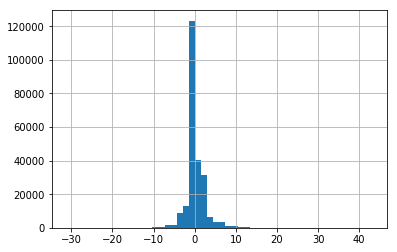

In [33]:
fin_df['sentiment'].hist(bins=50) 

In [36]:
fin_df['lang_2_str'] = fin_df['languages_2'].apply(lambda x: '_'.join(x))
mean_sent_for_langs = fin_df.groupby('lang_2_str')['sentiment'].mean().reset_index()
mean_sent_for_langs.head(3)

,lang_2_str,sentiment
0,,0.34293
1,A+,-0.40000
2,A+_K,1.00000


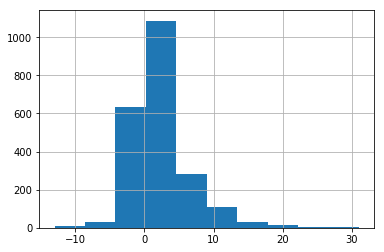

In [37]:
mean_sent_for_langs['sentiment'].hist()


суммарный сентимент-скор, если ЯП встречаются вместе:

In [38]:
mean_sent_for_langs[mean_sent_for_langs['sentiment'] < -10]

,lang_2_str,sentiment
115,B_M_C_D,-13.0
395,C_Scratch,-12.0
807,JSON_Bash,-13.0
1803,Rust_C++_Go_ECMAScript,-11.0
2063,T_JavaScript_Smalltalk_G,-12.0


In [39]:
mean_sent_for_langs[mean_sent_for_langs['sentiment'] > 20]

,lang_2_str,sentiment
789,Hope_Go,28.0
942,Java_XL,25.0
1693,Ruby_C++_Python_C#,21.0
1702,Ruby_Clojure,22.0
2061,T_G_P_R_S_K,31.0
2097,Tom_Ruby_Python_P,25.0
2124,TypeScript_Java_Delphi_JavaScript_Plus_Self_Smalltalk,21.0


_______________________

_______________________

_______________________

In [ ]:
html_tags = list(map(lambda x: '<{}>'.format(x.strip()), """a abbr address area article aside audio b base bdi bdo blockquote body br button canvas caption cite code col colgroup data datalist dd del dfn div dl dt em embed fieldset figcaption figure footer form h1 - h6 head header hr html i iframe img input ins kbd keygen label legend li link main map mark meta meter nav noscript object ol optgroup option output p param pre progress q rb rp rt rtc ruby s samp script section select small source span strong style sub sup table tbody td template textarea tfoot th thead time title tr track u ul var video wbr"""\
    .split()))